In [1]:
import numpy as np
from keras.preprocessing import image
from keras.applications import inception_v3
from keras import backend as K
from PIL import Image

import matplotlib.pyplot as plt

# Load pre-trained image recognition model
model = inception_v3.InceptionV3(weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')

# Grab a reference to the first and last layer of the neural net
model_input_layer = model.layers[0].input
model_output_layer = model.layers[-1].output

# Choose an ImageNet object to fake
# The list of classes is available here: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b
# Class #859 is "toaster"
object_type_to_fake = 859

# Load the image to hack
img = image.load_img("cat.png", target_size=(299, 299))
original_image = image.img_to_array(img)

# Scale the image so all pixel intensities are between [-1, 1] as the model expects
original_image /= 255.
original_image -= 0.5
original_image *= 2.

# Add a 4th dimension for batch size (as Keras expects)
original_image = np.expand_dims(original_image, axis=0)

# Pre-calculate the maximum change we will allow to the image
# We'll make sure our hacked image never goes past this so it doesn't look funny.
# A larger number produces an image faster but risks more distortion.
max_change_above = original_image + 0.01
max_change_below = original_image - 0.01

# Create a copy of the input image to hack on
hacked_image = np.copy(original_image)

# How much to update the hacked image in each iteration
learning_rate = 0.1

# Define the cost function.
# Our 'cost' will be the likelihood out image is the target class according to the pre-trained model
cost_function = model_output_layer[0, object_type_to_fake]
all_predict = model_output_layer
# We'll ask Keras to calculate the gradient based on the input image and the currently predicted class
# In this case, referring to "model_input_layer" will give us back image we are hacking.
gradient_function = K.gradients(cost_function, model_input_layer)[0]

# Create a Keras function that we can call to calculate the current cost and gradient
grab_cost_and_gradients_from_model = K.function([model_input_layer, K.learning_phase()], [cost_function, gradient_function, all_predict])

cost = 0.0

# In a loop, keep adjusting the hacked image slightly so that it tricks the model more and more
# until it gets to at least 80% confidence
while cost < 0.80:
    # Check how close the image is to our target class and grab the gradients we
    # can use to push it one more step in that direction.
    # Note: It's really important to pass in '0' for the Keras learning mode here!
    # Keras layers behave differently in prediction vs. train modes!
    cost, gradients,all_predict = grab_cost_and_gradients_from_model([hacked_image, 0])

    # Move the hacked image one step further towards fooling the model
    hacked_image += gradients * learning_rate

    # Ensure that the image doesn't ever change too much to either look funny or to become an invalid image
    hacked_image = np.clip(hacked_image, max_change_below, max_change_above)
    hacked_image = np.clip(hacked_image, -1.0, 1.0)
    # 1
    print("Model's predicted likelihood that the image is a toaster: {:.8}%".format(cost * 100))
    print( np.argsort(all_predict[0])[-5:])
    print( np.sort(all_predict[0])[-5:])
    # im = Image.fromarray(img.astype(np.uint8))
    # plt.imshow(hacked_image[0])

    # 2
    # now_image = (hacked_image[0]/2 + 0.5)
    # now_image = now_image.astype(np.uint8)
    # now_image = np.expand_dims(now_image, axis=0)
    # now_cost,now_gradients,now_predict = grab_cost_and_gradients_from_model([now_image, 0])
    # print("now the image is a toaster: {:.8}%".format(now_cost * 100))

    # 3
    # now_image = (hacked_image[0]/2 + 0.5)*255
    # now_image = now_image.astype(np.uint8)
    # now_image = np.expand_dims(now_image, axis=0)
    # now_cost,now_gradients,now_predict = grab_cost_and_gradients_from_model([now_image, 0])

    # print("now the image is a toaster: {:.8}%".format(now_cost * 100))



# plt.figure()
# plt.imshow(hacked_image[0])
# plt.show()
# plt.figure()
# plt.imshow(now_image[0])
# plt.show()
# # De-scale the image's pixels from [-1, 1] back to the [0, 255] range
# img = hacked_image[0]
# img /= 2.
# img += 0.5
# img *= 255.

# # Save the hacked image!
# im = Image.fromarray(img.astype(np.uint8))
# im.save("hacked-image.png")



Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

Model's predicted likelihood that the image is a toaster: 0.0036123012%
[380 152 588 332 283]
[0.00107307 0.00126073 0.00140249 0.00664854 0.84007514]
Model's predicted likelihood that the image is a toaster: 0.0036137659%
[380 152 588 332 283]
[0.00107331 0.00126094 0.00140286 0.00665075 0.84003675]
Model's predicted likelihood that the image is a toaster: 0.0036152436%
[380 152 588 332 283]
[0.00107355 0.00126115 0.00140323 0.006653   0.83999807]
Model's predicted likelihood that the image is a toaster: 0.0036166915%
[380 152 588 332 283]
[0.00107378 0.00126136 0.00140359 0.00665522 0.83995634]
Model's predicted likelihood that the image is a toaster: 0.0036181853%
[380 152 588 332 283]
[0.00107403 0.00126158 0.00140397 0.00665749 0.8399187 ]
Model's predicted likelihood that the image is a toaster: 0.0036196343%
[380 152 588 332 283]
[0.00107427 0.00126179 0.00140433 0.00665968 0.8398769 ]
Model's predicted likelihood that the image is a toaster: 0.0036211139%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0036950594%
[380 152 588 332 283]
[0.00108646 0.00127248 0.00142333 0.00677561 0.8378548 ]
Model's predicted likelihood that the image is a toaster: 0.0036966372%
[380 152 588 332 283]
[0.00108671 0.0012727  0.00142373 0.00677811 0.83781296]
Model's predicted likelihood that the image is a toaster: 0.0036981972%
[380 152 588 332 283]
[0.00108696 0.00127292 0.00142412 0.00678056 0.837771  ]
Model's predicted likelihood that the image is a toaster: 0.0036997713%
[380 152 588 332 283]
[0.00108722 0.00127314 0.00142452 0.00678303 0.83773047]
Model's predicted likelihood that the image is a toaster: 0.0037013499%
[380 152 588 332 283]
[0.00108747 0.00127336 0.00142492 0.00678552 0.83768827]
Model's predicted likelihood that the image is a toaster: 0.0037029331%
[380 152 588 332 283]
[0.00108772 0.00127358 0.00142531 0.00678801 0.8376455 ]
Model's predicted likelihood that the image is a toaster: 0.0037045171%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0037827835%
[380 152 588 332 283]
[0.00110037 0.0012847  0.00144511 0.00691237 0.83553064]
Model's predicted likelihood that the image is a toaster: 0.0037844031%
[380 152 588 332 283]
[0.00110062 0.00128492 0.0014455  0.00691488 0.83548915]
Model's predicted likelihood that the image is a toaster: 0.0037860122%
[380 152 588 332 283]
[0.00110087 0.00128514 0.0014459  0.00691736 0.83544666]
Model's predicted likelihood that the image is a toaster: 0.0037876496%
[380 152 588 332 283]
[0.00110113 0.00128537 0.0014463  0.00691992 0.8354039 ]
Model's predicted likelihood that the image is a toaster: 0.0037892536%
[380 152 588 332 283]
[0.00110138 0.00128558 0.00144668 0.00692237 0.8353617 ]
Model's predicted likelihood that the image is a toaster: 0.0037908772%
[380 152 588 332 283]
[0.00110163 0.00128581 0.00144708 0.00692489 0.83531886]
Model's predicted likelihood that the image is a toaster: 0.0037925012%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0038720558%
[380 152 588 332 283]
[0.00111409 0.00129692 0.00146656 0.00704929 0.8332179 ]
Model's predicted likelihood that the image is a toaster: 0.0038737136%
[380 152 588 332 283]
[0.00111435 0.00129715 0.00146696 0.00705183 0.8331757 ]
Model's predicted likelihood that the image is a toaster: 0.0038753584%
[380 152 588 332 283]
[0.0011146  0.00129738 0.00146735 0.00705431 0.8331329 ]
Model's predicted likelihood that the image is a toaster: 0.0038770198%
[380 152 588 332 283]
[0.00111485 0.00129761 0.00146775 0.00705683 0.83309114]
Model's predicted likelihood that the image is a toaster: 0.0038786613%
[380 152 588 332 283]
[0.00111509 0.00129783 0.00146814 0.0070593  0.8330481 ]
Model's predicted likelihood that the image is a toaster: 0.0038802988%
[380 152 588 332 283]
[0.00111534 0.00129806 0.00146853 0.00706178 0.83300644]
Model's predicted likelihood that the image is a toaster: 0.0038819893%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0039650757%
[380 152 588 332 283]
[0.00112806 0.00130971 0.00148862 0.00719172 0.8308355 ]
Model's predicted likelihood that the image is a toaster: 0.0039668084%
[380 152 588 332 283]
[0.00112831 0.00130994 0.00148903 0.00719441 0.83079123]
Model's predicted likelihood that the image is a toaster: 0.0039685707%
[380 152 588 332 283]
[0.00112858 0.00131019 0.00148945 0.00719715 0.8307458 ]
Model's predicted likelihood that the image is a toaster: 0.0039703056%
[380 152 588 332 283]
[0.00112883 0.00131042 0.00148985 0.00719986 0.8307033 ]
Model's predicted likelihood that the image is a toaster: 0.00397205%
[380 152 588 332 283]
[0.00112909 0.00131065 0.00149027 0.00720255 0.8306571 ]
Model's predicted likelihood that the image is a toaster: 0.0039737901%
[380 152 588 332 283]
[0.00112935 0.00131089 0.00149068 0.00720529 0.83061373]
Model's predicted likelihood that the image is a toaster: 0.0039755498%
[380 152 588 332 283]
[0

Model's predicted likelihood that the image is a toaster: 0.0040664334%
[380 152 588 332 283]
[0.0011427  0.0013232  0.00151239 0.0073444  0.8283003 ]
Model's predicted likelihood that the image is a toaster: 0.0040683026%
[380 152 588 332 283]
[0.00114297 0.00132345 0.00151282 0.00734716 0.82825434]
Model's predicted likelihood that the image is a toaster: 0.0040701718%
[380 152 588 332 283]
[0.00114324 0.00132369 0.00151326 0.00734998 0.8282083 ]
Model's predicted likelihood that the image is a toaster: 0.0040720475%
[380 152 588 332 283]
[0.00114351 0.00132394 0.00151371 0.00735279 0.8281602 ]
Model's predicted likelihood that the image is a toaster: 0.004073936%
[380 152 588 332 283]
[0.00114378 0.00132419 0.00151415 0.00735559 0.8281138 ]
Model's predicted likelihood that the image is a toaster: 0.0040758165%
[380 152 588 332 283]
[0.00114405 0.00132444 0.00151459 0.00735845 0.8280679 ]
Model's predicted likelihood that the image is a toaster: 0.0040776973%
[380 152 588 332 283]
[

Model's predicted likelihood that the image is a toaster: 0.0041717143%
[380 152 588 332 283]
[0.00115759 0.00133679 0.00153698 0.00750098 0.8256972 ]
Model's predicted likelihood that the image is a toaster: 0.0041737047%
[380 152 588 332 283]
[0.00115787 0.00133704 0.00153745 0.00750392 0.82564926]
Model's predicted likelihood that the image is a toaster: 0.0041756619%
[380 152 588 332 283]
[0.00115814 0.00133729 0.00153791 0.00750684 0.82560015]
Model's predicted likelihood that the image is a toaster: 0.0041776493%
[380 152 588 332 283]
[0.00115842 0.00133754 0.00153837 0.00750974 0.8255536 ]
Model's predicted likelihood that the image is a toaster: 0.0041796287%
[380 152 588 332 283]
[0.00115869 0.00133779 0.00153883 0.00751266 0.82550377]
Model's predicted likelihood that the image is a toaster: 0.0041816234%
[380 152 588 332 283]
[0.00115897 0.00133804 0.00153929 0.00751558 0.8254568 ]
Model's predicted likelihood that the image is a toaster: 0.0041836112%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0042830517%
[380 152 588 332 283]
[0.00117304 0.00135098 0.00156282 0.00766196 0.8229811 ]
Model's predicted likelihood that the image is a toaster: 0.0042851036%
[380 152 588 332 283]
[0.00117332 0.00135124 0.00156329 0.00766491 0.8229326 ]
Model's predicted likelihood that the image is a toaster: 0.0042871823%
[380 152 588 332 283]
[0.00117361 0.00135151 0.00156377 0.00766789 0.8228813 ]
Model's predicted likelihood that the image is a toaster: 0.0042892618%
[380 152 588 332 283]
[0.0011739  0.00135177 0.00156425 0.00767086 0.82283145]
Model's predicted likelihood that the image is a toaster: 0.0042913514%
[380 152 588 332 283]
[0.00117419 0.00135204 0.00156474 0.00767387 0.82278097]
Model's predicted likelihood that the image is a toaster: 0.004293432%
[380 152 588 332 283]
[0.00117448 0.0013523  0.00156521 0.00767685 0.8227302 ]
Model's predicted likelihood that the image is a toaster: 0.004295534%
[380 152 588 332 283]
[0

Model's predicted likelihood that the image is a toaster: 0.004400171%
[380 152 588 332 283]
[0.00118912 0.00136559 0.00158952 0.00783066 0.8201652 ]
Model's predicted likelihood that the image is a toaster: 0.0044023436%
[380 152 588 332 283]
[0.00118941 0.00136586 0.00159001 0.00783376 0.8201125 ]
Model's predicted likelihood that the image is a toaster: 0.0044045424%
[380 152 588 332 283]
[0.00118971 0.00136612 0.00159051 0.00783695 0.82005906]
Model's predicted likelihood that the image is a toaster: 0.004406755%
[380 152 588 332 283]
[0.00119001 0.00136639 0.001591   0.00784011 0.8200063 ]
Model's predicted likelihood that the image is a toaster: 0.0044089742%
[380 152 588 332 283]
[0.00119031 0.00136667 0.0015915  0.00784331 0.81995463]
Model's predicted likelihood that the image is a toaster: 0.0044111839%
[380 152 588 332 283]
[0.0011906  0.00136694 0.001592   0.00784652 0.81990254]
Model's predicted likelihood that the image is a toaster: 0.0044134111%
[380 152 588 332 283]
[0

Model's predicted likelihood that the image is a toaster: 0.0045243432%
[380 152 588 332 283]
[0.0012057  0.00138086 0.00161724 0.00800963 0.81722236]
Model's predicted likelihood that the image is a toaster: 0.0045266948%
[380 152 588 332 283]
[0.00120601 0.00138114 0.00161776 0.00801303 0.8171662 ]
Model's predicted likelihood that the image is a toaster: 0.0045290617%
[380 152 588 332 283]
[0.00120632 0.00138143 0.00161829 0.00801642 0.8171125 ]
Model's predicted likelihood that the image is a toaster: 0.0045314326%
[380 152 588 332 283]
[0.00120663 0.00138171 0.00161881 0.00801983 0.81705624]
Model's predicted likelihood that the image is a toaster: 0.0045338253%
[380 152 588 332 283]
[0.00120694 0.001382   0.00161935 0.00802329 0.8170013 ]
Model's predicted likelihood that the image is a toaster: 0.0045361881%
[380 152 588 332 283]
[0.00120725 0.00138229 0.00161987 0.00802673 0.8169447 ]
Model's predicted likelihood that the image is a toaster: 0.0045385434%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0046577126%
[380 152 588 332 283]
[0.00122286 0.0013968  0.00164663 0.00820289 0.81411654]
Model's predicted likelihood that the image is a toaster: 0.0046602265%
[380 152 588 332 283]
[0.00122317 0.0013971  0.00164718 0.00820659 0.81405896]
Model's predicted likelihood that the image is a toaster: 0.0046627436%
[380 152 588 332 283]
[0.00122349 0.0013974  0.00164773 0.00821025 0.8139985 ]
Model's predicted likelihood that the image is a toaster: 0.0046652818%
[380 152 588 332 283]
[0.00122381 0.0013977  0.00164828 0.00821395 0.8139424 ]
Model's predicted likelihood that the image is a toaster: 0.0046678124%
[380 152 588 332 283]
[0.00122414 0.00139799 0.00164883 0.0082177  0.81388307]
Model's predicted likelihood that the image is a toaster: 0.0046703492%
[380 152 588 332 283]
[0.00122446 0.00139829 0.00164938 0.00822139 0.81382465]
Model's predicted likelihood that the image is a toaster: 0.0046728739%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0047999602%
[380 152 588 332 283]
[0.00124065 0.00141334 0.00167735 0.00840906 0.8108648 ]
Model's predicted likelihood that the image is a toaster: 0.004802586%
[380 152 588 332 283]
[0.00124098 0.00141364 0.00167791 0.0084129  0.8108049 ]
Model's predicted likelihood that the image is a toaster: 0.0048052309%
[380 152 588 332 283]
[0.00124131 0.00141395 0.00167848 0.00841678 0.8107448 ]
Model's predicted likelihood that the image is a toaster: 0.0048078455%
[380 152 588 332 283]
[0.00124163 0.00141425 0.00167905 0.00842064 0.8106856 ]
Model's predicted likelihood that the image is a toaster: 0.004810467%
[380 152 588 332 283]
[0.00124195 0.00141455 0.00167961 0.00842448 0.8106234 ]
Model's predicted likelihood that the image is a toaster: 0.004813102%
[380 152 588 332 283]
[0.00124227 0.00141486 0.00168019 0.00842838 0.8105664 ]
Model's predicted likelihood that the image is a toaster: 0.0048157293%
[380 152 588 332 283]
[0.

Model's predicted likelihood that the image is a toaster: 0.0049453698%
[380 152 588 332 283]
[0.0012583  0.0014299  0.00170903 0.00862708 0.80756176]
Model's predicted likelihood that the image is a toaster: 0.0049480732%
[380 152 588 332 283]
[0.00125862 0.0014302  0.00170962 0.00863115 0.80750096]
Model's predicted likelihood that the image is a toaster: 0.0049507587%
[380 152 588 332 283]
[0.00125895 0.00143051 0.0017102  0.00863521 0.8074393 ]
Model's predicted likelihood that the image is a toaster: 0.0049534381%
[380 152 588 332 283]
[0.00125927 0.00143081 0.00171079 0.00863931 0.80737877]
Model's predicted likelihood that the image is a toaster: 0.0049561429%
[380 152 588 332 283]
[0.0012596  0.00143111 0.00171139 0.0086434  0.80731976]
Model's predicted likelihood that the image is a toaster: 0.0049588347%
[380 152 588 332 283]
[0.00125992 0.00143141 0.00171197 0.00864748 0.8072584 ]
Model's predicted likelihood that the image is a toaster: 0.0049615304%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0050947954%
[380 152 588 332 283]
[0.00127602 0.00144642 0.00174156 0.00885456 0.8041984 ]
Model's predicted likelihood that the image is a toaster: 0.0050976585%
[380 152 588 332 283]
[0.00127636 0.00144673 0.00174217 0.00885883 0.8041364 ]
Model's predicted likelihood that the image is a toaster: 0.0051004958%
[380 152 588 332 283]
[0.00127668 0.00144703 0.00174277 0.00886303 0.80407304]
Model's predicted likelihood that the image is a toaster: 0.0051033578%
[380 152 588 332 283]
[0.00127702 0.00144735 0.00174338 0.00886728 0.8040104 ]
Model's predicted likelihood that the image is a toaster: 0.0051062227%
[380 152 588 332 283]
[0.00127735 0.00144766 0.00174399 0.00887148 0.8039486 ]
Model's predicted likelihood that the image is a toaster: 0.0051090694%
[380 152 588 332 283]
[0.00127768 0.00144797 0.00174459 0.0088757  0.80388534]
Model's predicted likelihood that the image is a toaster: 0.0051119201%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0052559924%
[380 152 588 332 283]
[0.00129458 0.00146397 0.00177576 0.00909266 0.8006686 ]
Model's predicted likelihood that the image is a toaster: 0.0052590167%
[380 152 588 332 283]
[0.00129493 0.0014643  0.0017764  0.00909713 0.8006031 ]
Model's predicted likelihood that the image is a toaster: 0.0052620195%
[380 152 588 332 283]
[0.00129527 0.00146462 0.00177702 0.00910152 0.80053556]
Model's predicted likelihood that the image is a toaster: 0.0052650234%
[380 152 588 332 283]
[0.00129561 0.00146495 0.00177766 0.00910595 0.8004717 ]
Model's predicted likelihood that the image is a toaster: 0.0052680422%
[380 152 588 332 283]
[0.00129595 0.00146527 0.00177829 0.00911033 0.8004069 ]
Model's predicted likelihood that the image is a toaster: 0.0052710515%
[380 152 588 332 283]
[0.00129629 0.0014656  0.00177893 0.00911471 0.8003426 ]
Model's predicted likelihood that the image is a toaster: 0.0052740783%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0054285942%
[380 152 588 332 283]
[0.00131369 0.00148229 0.00181181 0.00934277 0.7969676 ]
Model's predicted likelihood that the image is a toaster: 0.0054318822%
[380 152 588 332 283]
[0.00131405 0.00148263 0.00181249 0.00934743 0.7968984 ]
Model's predicted likelihood that the image is a toaster: 0.0054352095%
[380 152 588 332 283]
[0.00131441 0.00148298 0.00181318 0.00935213 0.7968278 ]
Model's predicted likelihood that the image is a toaster: 0.0054385211%
[380 152 588 332 283]
[0.00131477 0.00148332 0.00181386 0.00935688 0.79675764]
Model's predicted likelihood that the image is a toaster: 0.0054418415%
[380 152 588 332 283]
[0.00131513 0.00148367 0.00181455 0.00936164 0.79668623]
Model's predicted likelihood that the image is a toaster: 0.0054451699%
[380 152 588 332 283]
[0.00131549 0.00148401 0.00181524 0.00936643 0.7966172 ]
Model's predicted likelihood that the image is a toaster: 0.0054485146%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0056167464%
[380 152 588 332 283]
[0.00133368 0.00150152 0.0018505  0.00961243 0.79298925]
Model's predicted likelihood that the image is a toaster: 0.0056202502%
[380 152 588 332 283]
[0.00133406 0.00150188 0.00185122 0.00961748 0.7929181 ]
Model's predicted likelihood that the image is a toaster: 0.0056237313%
[380 152 588 332 283]
[0.00133442 0.00150223 0.00185193 0.00962244 0.79284495]
Model's predicted likelihood that the image is a toaster: 0.0056272245%
[380 152 588 332 283]
[0.00133479 0.00150259 0.00185266 0.00962751 0.7927717 ]
Model's predicted likelihood that the image is a toaster: 0.0056307192%
[380 152 588 332 283]
[0.00133516 0.00150294 0.00185337 0.00963255 0.79269534]
Model's predicted likelihood that the image is a toaster: 0.0056342251%
[380 152 588 332 283]
[0.00133553 0.0015033  0.0018541  0.0096376  0.79262334]
Model's predicted likelihood that the image is a toaster: 0.0056377336%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0058152185%
[380 152 588 332 283]
[0.00135451 0.00152162 0.00189123 0.00989995 0.78882694]
Model's predicted likelihood that the image is a toaster: 0.0058189697%
[380 152 588 332 283]
[0.00135491 0.001522   0.001892   0.00990547 0.7887481 ]
Model's predicted likelihood that the image is a toaster: 0.0058227186%
[380 152 588 332 283]
[0.0013553  0.00152238 0.00189278 0.0099109  0.7886694 ]
Model's predicted likelihood that the image is a toaster: 0.0058264999%
[380 152 588 332 283]
[0.0013557  0.00152276 0.00189356 0.0099164  0.7885894 ]
Model's predicted likelihood that the image is a toaster: 0.0058303027%
[380 152 588 332 283]
[0.00135609 0.00152314 0.00189434 0.00992194 0.78851056]
Model's predicted likelihood that the image is a toaster: 0.0058341247%
[380 152 588 332 283]
[0.00135648 0.00152352 0.00189514 0.00992753 0.7884317 ]
Model's predicted likelihood that the image is a toaster: 0.0058379683%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0060289374%
[380 152 588 332 283]
[0.00137628 0.00154271 0.00193456 0.01020808 0.7844283 ]
Model's predicted likelihood that the image is a toaster: 0.0060329356%
[380 152 588 332 283]
[0.00137668 0.00154311 0.00193535 0.0102138  0.78434694]
Model's predicted likelihood that the image is a toaster: 0.0060368777%
[380 152 588 332 283]
[0.00137708 0.0015435  0.00193613 0.01021931 0.7842668 ]
Model's predicted likelihood that the image is a toaster: 0.0060408503%
[380 152 588 332 283]
[0.00137748 0.00154389 0.00193692 0.01022494 0.78418666]
Model's predicted likelihood that the image is a toaster: 0.0060448485%
[380 152 588 332 283]
[0.00137789 0.00154429 0.0019377  0.01023062 0.7841042 ]
Model's predicted likelihood that the image is a toaster: 0.0060488375%
[380 152 588 332 283]
[0.00137829 0.00154468 0.00193848 0.01023626 0.7840248 ]
Model's predicted likelihood that the image is a toaster: 0.006052804%
[380 152 588 332 283]
[

Model's predicted likelihood that the image is a toaster: 0.006255092%
[380 152 588 332 283]
[0.00139875 0.00156498 0.00197805 0.01051746 0.7798707 ]
Model's predicted likelihood that the image is a toaster: 0.006259315%
[380 152 588 332 283]
[0.00139916 0.0015654  0.00197885 0.01052316 0.7797879 ]
Model's predicted likelihood that the image is a toaster: 0.0062634877%
[380 152 588 332 283]
[0.00139957 0.00156581 0.00197965 0.01052873 0.7797031 ]
Model's predicted likelihood that the image is a toaster: 0.0062677129%
[380 152 588 332 283]
[0.00139998 0.00156622 0.00198045 0.01053442 0.7796198 ]
Model's predicted likelihood that the image is a toaster: 0.0062719126%
[380 152 588 332 283]
[0.00140039 0.00156663 0.00198125 0.01054008 0.7795353 ]
Model's predicted likelihood that the image is a toaster: 0.0062761101%
[380 152 588 332 283]
[0.0014008  0.00156704 0.00198204 0.01054567 0.77945095]
Model's predicted likelihood that the image is a toaster: 0.0062803214%
[380 152 588 332 283]
[0

Model's predicted likelihood that the image is a toaster: 0.0064949454%
[380 152 588 332 283]
[0.00142227 0.00158791 0.00202256 0.01083024 0.775175  ]
Model's predicted likelihood that the image is a toaster: 0.0064995067%
[380 152 588 332 283]
[0.00142274 0.00158834 0.0020234  0.0108362  0.7750871 ]
Model's predicted likelihood that the image is a toaster: 0.0065040513%
[380 152 588 332 283]
[0.0014232  0.00158878 0.00202423 0.01084213 0.7749969 ]
Model's predicted likelihood that the image is a toaster: 0.0065085442%
[380 152 588 332 283]
[0.00142365 0.00158921 0.00202505 0.01084786 0.77491045]
Model's predicted likelihood that the image is a toaster: 0.0065130684%
[380 152 588 332 283]
[0.0014241  0.00158964 0.00202587 0.01085375 0.77482224]
Model's predicted likelihood that the image is a toaster: 0.0065176137%
[380 152 588 332 283]
[0.00142456 0.00159008 0.0020267  0.01085954 0.7747347 ]
Model's predicted likelihood that the image is a toaster: 0.0065221742%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0067526562%
[380 152 588 332 283]
[0.00144779 0.00161203 0.00206905 0.01115193 0.7702545 ]
Model's predicted likelihood that the image is a toaster: 0.0067575718%
[380 152 588 332 283]
[0.00144828 0.00161247 0.00206994 0.01115794 0.7701598 ]
Model's predicted likelihood that the image is a toaster: 0.0067625093%
[380 152 588 332 283]
[0.00144877 0.00161293 0.00207083 0.01116401 0.77006495]
Model's predicted likelihood that the image is a toaster: 0.0067674489%
[380 152 588 332 283]
[0.00144926 0.00161338 0.00207172 0.01117005 0.76997215]
Model's predicted likelihood that the image is a toaster: 0.0067724322%
[380 152 588 332 283]
[0.00144975 0.00161383 0.00207262 0.0111762  0.7698787 ]
Model's predicted likelihood that the image is a toaster: 0.006777385%
[380 152 588 332 283]
[0.00145024 0.00161428 0.00207351 0.01118223 0.76978374]
Model's predicted likelihood that the image is a toaster: 0.0067823858%
[380 152 588 332 283]
[

Model's predicted likelihood that the image is a toaster: 0.0070334965%
[380 152 588 332 283]
[0.00147494 0.00163704 0.00211942 0.01148739 0.7650059 ]
Model's predicted likelihood that the image is a toaster: 0.0070387308%
[380 152 588 332 283]
[0.00147544 0.00163749 0.00212034 0.01149348 0.76490813]
Model's predicted likelihood that the image is a toaster: 0.007043995%
[380 152 588 332 283]
[0.00147594 0.00163795 0.00212129 0.01149958 0.7648118 ]
Model's predicted likelihood that the image is a toaster: 0.0070492482%
[380 152 588 332 283]
[0.00147644 0.0016384  0.00212222 0.01150563 0.7647153 ]
Model's predicted likelihood that the image is a toaster: 0.0070545022%
[380 152 588 332 283]
[0.00147693 0.00163886 0.00212315 0.01151171 0.7646178 ]
Model's predicted likelihood that the image is a toaster: 0.0070597613%
[380 152 588 332 283]
[0.00147743 0.00163932 0.00212409 0.01151782 0.76452106]
Model's predicted likelihood that the image is a toaster: 0.0070650152%
[380 152 588 332 283]
[

Model's predicted likelihood that the image is a toaster: 0.0073272669%
[380 152 588 332 283]
[0.00150228 0.0016621  0.00217109 0.01182976 0.7596335 ]
Model's predicted likelihood that the image is a toaster: 0.0073328905%
[380 152 588 332 283]
[0.00150279 0.00166257 0.00217208 0.01183664 0.75953245]
Model's predicted likelihood that the image is a toaster: 0.0073385403%
[380 152 588 332 283]
[0.00150331 0.00166304 0.00217306 0.01184347 0.75943005]
Model's predicted likelihood that the image is a toaster: 0.0073442272%
[380 152 588 332 283]
[0.00150383 0.00166352 0.00217406 0.01185042 0.75932664]
Model's predicted likelihood that the image is a toaster: 0.0073499221%
[380 152 588 332 283]
[0.00150434 0.00166399 0.00217506 0.01185735 0.75922364]
Model's predicted likelihood that the image is a toaster: 0.0073556585%
[380 152 588 332 283]
[0.00150487 0.00166447 0.00217607 0.01186423 0.75911945]
Model's predicted likelihood that the image is a toaster: 0.0073613744%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.007654271%
[380 152 588 332 283]
[0.00153127 0.00168935 0.00222724 0.01221865 0.7537688 ]
Model's predicted likelihood that the image is a toaster: 0.0076604018%
[380 152 588 332 283]
[0.0015318  0.00168985 0.00222828 0.01222571 0.75366133]
Model's predicted likelihood that the image is a toaster: 0.0076665041%
[380 152 588 332 283]
[0.00153232 0.00169035 0.0022293  0.01223281 0.7535521 ]
Model's predicted likelihood that the image is a toaster: 0.0076725868%
[380 152 588 332 283]
[0.00153284 0.00169084 0.00223032 0.01223987 0.7534433 ]
Model's predicted likelihood that the image is a toaster: 0.0076787219%
[380 152 588 332 283]
[0.00153337 0.00169135 0.00223137 0.01224703 0.75333494]
Model's predicted likelihood that the image is a toaster: 0.007684806%
[380 152 588 332 283]
[0.00153389 0.00169184 0.00223238 0.01225412 0.7532268 ]
Model's predicted likelihood that the image is a toaster: 0.0076909768%
[380 152 588 332 283]
[0

Model's predicted likelihood that the image is a toaster: 0.0080077683%
[380 152 588 332 283]
[0.00156129 0.00171849 0.00228629 0.01263147 0.7475481 ]
Model's predicted likelihood that the image is a toaster: 0.0080145939%
[380 152 588 332 283]
[0.00156187 0.00171905 0.00228742 0.01263963 0.7474286 ]
Model's predicted likelihood that the image is a toaster: 0.0080214144%
[380 152 588 332 283]
[0.00156244 0.00171961 0.00228854 0.01264765 0.7473096 ]
Model's predicted likelihood that the image is a toaster: 0.0080282538%
[380 152 588 332 283]
[0.00156301 0.00172016 0.00228967 0.01265586 0.7471917 ]
Model's predicted likelihood that the image is a toaster: 0.0080351529%
[380 152 588 332 283]
[0.00156358 0.00172071 0.0022908  0.01266405 0.74707115]
Model's predicted likelihood that the image is a toaster: 0.008042041%
[380 152 588 332 283]
[0.00156416 0.00172126 0.00229194 0.01267219 0.7469518 ]
Model's predicted likelihood that the image is a toaster: 0.0080489823%
[380 152 588 332 283]
[

Model's predicted likelihood that the image is a toaster: 0.0084055981%
[380 152 588 332 283]
[0.00159429 0.00175014 0.00235127 0.01309651 0.74073327]
Model's predicted likelihood that the image is a toaster: 0.0084130792%
[380 152 588 332 283]
[0.00159491 0.00175071 0.00235247 0.01310512 0.7406067 ]
Model's predicted likelihood that the image is a toaster: 0.0084206418%
[380 152 588 332 283]
[0.00159553 0.0017513  0.00235367 0.01311384 0.7404783 ]
Model's predicted likelihood that the image is a toaster: 0.0084281033%
[380 152 588 332 283]
[0.00159614 0.00175187 0.00235485 0.01312222 0.74035174]
Model's predicted likelihood that the image is a toaster: 0.0084355728%
[380 152 588 332 283]
[0.00159675 0.00175245 0.00235604 0.01313076 0.74022734]
Model's predicted likelihood that the image is a toaster: 0.0084430554%
[380 152 588 332 283]
[0.00159735 0.00175301 0.00235722 0.01313928 0.7401001 ]
Model's predicted likelihood that the image is a toaster: 0.0084505882%
[380 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0088330613%
[229 152 588 332 283]
[0.00163527 0.00178204 0.00241775 0.01356218 0.7336392 ]
Model's predicted likelihood that the image is a toaster: 0.008841075%
[229 152 588 332 283]
[0.00163613 0.00178263 0.00241895 0.01357056 0.733509  ]
Model's predicted likelihood that the image is a toaster: 0.0088490604%
[229 152 588 332 283]
[0.00163698 0.00178322 0.00242015 0.01357881 0.7333786 ]
Model's predicted likelihood that the image is a toaster: 0.0088570763%
[229 152 588 332 283]
[0.00163784 0.00178381 0.00242135 0.01358713 0.7332482 ]
Model's predicted likelihood that the image is a toaster: 0.0088651039%
[229 152 588 332 283]
[0.0016387  0.0017844  0.00242256 0.01359543 0.73311734]
Model's predicted likelihood that the image is a toaster: 0.0088731322%
[229 152 588 332 283]
[0.00163957 0.001785   0.00242377 0.0136038  0.73298675]
Model's predicted likelihood that the image is a toaster: 0.0088812165%
[229 152 588 332 283]
[

Model's predicted likelihood that the image is a toaster: 0.0092848088%
[229 152 588 332 283]
[0.00168434 0.00181546 0.002484   0.014032   0.72634465]
Model's predicted likelihood that the image is a toaster: 0.0092934868%
[229 152 588 332 283]
[0.00168527 0.00181609 0.00248525 0.01404088 0.7262058 ]
Model's predicted likelihood that the image is a toaster: 0.0093022099%
[229 152 588 332 283]
[0.00168619 0.00181673 0.00248652 0.01404984 0.7260671 ]
Model's predicted likelihood that the image is a toaster: 0.0093109644%
[229 152 588 332 283]
[0.00168713 0.00181736 0.00248778 0.01405886 0.7259268 ]
Model's predicted likelihood that the image is a toaster: 0.0093197552%
[229 152 588 332 283]
[0.00168806 0.001818   0.00248905 0.01406796 0.725786  ]
Model's predicted likelihood that the image is a toaster: 0.0093285526%
[229 152 588 332 283]
[0.001689   0.00181863 0.00249033 0.01407708 0.72564644]
Model's predicted likelihood that the image is a toaster: 0.0093374263%
[229 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.0097805096%
[229 152 588 332 283]
[0.00173581 0.00185092 0.0025555  0.01453668 0.7185019 ]
Model's predicted likelihood that the image is a toaster: 0.0097894772%
[229 152 588 332 283]
[0.0017367  0.00185156 0.00255678 0.0145455  0.7183628 ]
Model's predicted likelihood that the image is a toaster: 0.0097984994%
[229 152 588 332 283]
[0.00173759 0.0018522  0.00255805 0.01455426 0.71822375]
Model's predicted likelihood that the image is a toaster: 0.0098075478%
[229 152 588 332 283]
[0.00173847 0.00185285 0.00255933 0.01456293 0.71808326]
Model's predicted likelihood that the image is a toaster: 0.0098165576%
[229 152 588 332 283]
[0.00173936 0.00185349 0.00256061 0.01457178 0.71794415]
Model's predicted likelihood that the image is a toaster: 0.0098255994%
[229 152 588 332 283]
[0.00174025 0.00185413 0.00256189 0.01458058 0.71780264]
Model's predicted likelihood that the image is a toaster: 0.0098346463%
[229 152 588 332 283]


Model's predicted likelihood that the image is a toaster: 0.010302811%
[229 152 588 332 283]
[0.00178679 0.00188777 0.00262904 0.01504607 0.71046066]
Model's predicted likelihood that the image is a toaster: 0.010313019%
[229 152 588 332 283]
[0.00178777 0.00188848 0.00263046 0.01505614 0.7103057 ]
Model's predicted likelihood that the image is a toaster: 0.010323239%
[229 152 588 332 283]
[0.00178876 0.00188918 0.00263188 0.01506628 0.71015036]
Model's predicted likelihood that the image is a toaster: 0.010333522%
[229 152 588 332 283]
[0.00178975 0.00188988 0.0026333  0.01507646 0.7099946 ]
Model's predicted likelihood that the image is a toaster: 0.010343789%
[229 152 588 332 283]
[0.00179073 0.00189058 0.00263473 0.01508651 0.70983845]
Model's predicted likelihood that the image is a toaster: 0.01035414%
[229 152 588 332 283]
[0.00179173 0.0018913  0.00263617 0.01509672 0.70968056]
Model's predicted likelihood that the image is a toaster: 0.010364476%
[229 152 588 332 283]
[0.00179

Model's predicted likelihood that the image is a toaster: 0.01089955%
[229 152 588 332 283]
[0.00184438 0.00192807 0.00271146 0.01562558 0.70149595]
Model's predicted likelihood that the image is a toaster: 0.010911126%
[229 152 588 332 283]
[0.00184548 0.00192882 0.00271303 0.01563659 0.7013254 ]
Model's predicted likelihood that the image is a toaster: 0.010922741%
[229 152 588 332 283]
[0.00184659 0.00192957 0.0027146  0.0156475  0.70115465]
Model's predicted likelihood that the image is a toaster: 0.010934326%
[229 152 588 332 283]
[0.00184768 0.00193031 0.00271616 0.0156584  0.70098454]
Model's predicted likelihood that the image is a toaster: 0.010946015%
[229 152 588 332 283]
[0.0018488  0.00193106 0.00271775 0.0156695  0.70081294]
Model's predicted likelihood that the image is a toaster: 0.010957584%
[229 152 588 332 283]
[0.00184989 0.0019318  0.00271931 0.01568028 0.70064235]
Model's predicted likelihood that the image is a toaster: 0.010969288%
[229 152 588 332 283]
[0.00185

Model's predicted likelihood that the image is a toaster: 0.011579696%
[258 152 588 332 283]
[0.00191015 0.00197068 0.0028021  0.01625244 0.69167495]
Model's predicted likelihood that the image is a toaster: 0.011592938%
[258 152 588 332 283]
[0.00191142 0.0019715  0.00280384 0.01626419 0.6914866 ]
Model's predicted likelihood that the image is a toaster: 0.01160627%
[258 152 588 332 283]
[0.0019127  0.00197233 0.00280559 0.01627609 0.69129616]
Model's predicted likelihood that the image is a toaster: 0.011619575%
[258 152 588 332 283]
[0.00191397 0.00197315 0.00280731 0.01628789 0.69110656]
Model's predicted likelihood that the image is a toaster: 0.011632947%
[258 152 588 332 283]
[0.00191525 0.00197398 0.00280906 0.01629968 0.6909168 ]
Model's predicted likelihood that the image is a toaster: 0.011646353%
[258 152 588 332 283]
[0.00191653 0.00197481 0.0028108  0.01631144 0.6907268 ]
Model's predicted likelihood that the image is a toaster: 0.011659774%
[258 152 588 332 283]
[0.00191

Model's predicted likelihood that the image is a toaster: 0.012334337%
[258 152 588 332 283]
[0.00198224 0.00201622 0.00289975 0.0169208  0.6810961 ]
Model's predicted likelihood that the image is a toaster: 0.012348662%
[258 152 588 332 283]
[0.00198362 0.00201706 0.0029016  0.01693377 0.6808974 ]
Model's predicted likelihood that the image is a toaster: 0.012363074%
[258 152 588 332 283]
[0.00198501 0.00201791 0.00290344 0.01694655 0.68069947]
Model's predicted likelihood that the image is a toaster: 0.012377517%
[258 152 588 332 283]
[0.00198641 0.00201876 0.00290529 0.0169594  0.68050164]
Model's predicted likelihood that the image is a toaster: 0.012391992%
[258 152 588 332 283]
[0.00198781 0.00201961 0.00290715 0.01697233 0.68030214]
Model's predicted likelihood that the image is a toaster: 0.012406503%
[258 152 588 332 283]
[0.0019892  0.00202046 0.00290901 0.01698516 0.68010247]
Model's predicted likelihood that the image is a toaster: 0.012421035%
[258 152 588 332 283]
[0.0019

Model's predicted likelihood that the image is a toaster: 0.013152494%
[258 152 588 332 283]
[0.00205988 0.00206263 0.00300342 0.01762579 0.6701206 ]
Model's predicted likelihood that the image is a toaster: 0.013167722%
[258 152 588 332 283]
[0.00206131 0.00206345 0.00300533 0.01763875 0.66992015]
Model's predicted likelihood that the image is a toaster: 0.01318297%
[258 152 588 332 283]
[0.00206274 0.00206426 0.00300724 0.01765163 0.6697212 ]
Model's predicted likelihood that the image is a toaster: 0.013198311%
[258 152 588 332 283]
[0.00206418 0.00206509 0.00300916 0.01766457 0.6695204 ]
Model's predicted likelihood that the image is a toaster: 0.013213718%
[258 152 588 332 283]
[0.00206562 0.00206591 0.00301109 0.01767739 0.6693176 ]
Model's predicted likelihood that the image is a toaster: 0.013229113%
[152 258 588 332 283]
[0.00206673 0.00206707 0.00301302 0.0176905  0.6691159 ]
Model's predicted likelihood that the image is a toaster: 0.013244609%
[152 258 588 332 283]
[0.00206

Model's predicted likelihood that the image is a toaster: 0.014061434%
[229 258 588 332 283]
[0.00212436 0.00214543 0.00311702 0.01839167 0.6583659 ]
Model's predicted likelihood that the image is a toaster: 0.014079422%
[229 258 588 332 283]
[0.00212586 0.0021471  0.00311925 0.01840692 0.65813833]
Model's predicted likelihood that the image is a toaster: 0.014097423%
[229 258 588 332 283]
[0.00212736 0.00214877 0.00312146 0.01842208 0.6579123 ]
Model's predicted likelihood that the image is a toaster: 0.014115505%
[229 258 588 332 283]
[0.00212886 0.00215045 0.00312367 0.01843729 0.65768397]
Model's predicted likelihood that the image is a toaster: 0.014133517%
[229 258 588 332 283]
[0.00213038 0.00215213 0.00312589 0.01845282 0.65745527]
Model's predicted likelihood that the image is a toaster: 0.014151577%
[229 258 588 332 283]
[0.00213191 0.00215382 0.00312812 0.01846871 0.65722644]
Model's predicted likelihood that the image is a toaster: 0.014169674%
[229 258 588 332 283]
[0.0021

Model's predicted likelihood that the image is a toaster: 0.015084386%
[229 258 588 332 283]
[0.00220731 0.00223833 0.00323729 0.0192572  0.64580345]
Model's predicted likelihood that the image is a toaster: 0.015103398%
[229 258 588 332 283]
[0.00220877 0.00223999 0.00323944 0.0192726  0.6455773 ]
Model's predicted likelihood that the image is a toaster: 0.01512241%
[229 258 588 332 283]
[0.00221023 0.00224163 0.00324159 0.01928822 0.6453509 ]
Model's predicted likelihood that the image is a toaster: 0.015141406%
[229 258 588 332 283]
[0.00221169 0.00224328 0.00324374 0.01930376 0.645124  ]
Model's predicted likelihood that the image is a toaster: 0.015160441%
[229 258 588 332 283]
[0.00221315 0.00224493 0.0032459  0.01931938 0.6448973 ]
Model's predicted likelihood that the image is a toaster: 0.015179596%
[229 258 588 332 283]
[0.00221461 0.00224658 0.00324805 0.01933472 0.644671  ]
Model's predicted likelihood that the image is a toaster: 0.015198754%
[229 258 588 332 283]
[0.00221

Model's predicted likelihood that the image is a toaster: 0.016182444%
[229 258 588 332 283]
[0.0022906  0.00233118 0.00335732 0.02011748 0.63304865]
Model's predicted likelihood that the image is a toaster: 0.016203479%
[229 258 588 332 283]
[0.00229216 0.00233293 0.00335954 0.0201331  0.6328115 ]
Model's predicted likelihood that the image is a toaster: 0.016224575%
[229 258 588 332 283]
[0.00229371 0.00233469 0.00336176 0.02014859 0.63257456]
Model's predicted likelihood that the image is a toaster: 0.016245688%
[229 258 588 332 283]
[0.00229528 0.00233644 0.00336399 0.02016418 0.63233787]
Model's predicted likelihood that the image is a toaster: 0.016266918%
[229 258 588 332 283]
[0.00229684 0.0023382  0.00336622 0.02017968 0.6320999 ]
Model's predicted likelihood that the image is a toaster: 0.016288181%
[229 258 588 332 283]
[0.00229838 0.00233993 0.00336844 0.02019496 0.63186353]
Model's predicted likelihood that the image is a toaster: 0.016309632%
[229 258 588 332 283]
[0.0022

Model's predicted likelihood that the image is a toaster: 0.017424583%
[229 258 588 332 283]
[0.0023815  0.00243315 0.00348533 0.02099303 0.6195579 ]
Model's predicted likelihood that the image is a toaster: 0.017448979%
[229 258 588 332 283]
[0.00238335 0.00243519 0.00348782 0.02101061 0.61930156]
Model's predicted likelihood that the image is a toaster: 0.017473359%
[229 258 588 332 283]
[0.00238519 0.00243723 0.00349031 0.02102822 0.6190447 ]
Model's predicted likelihood that the image is a toaster: 0.017497702%
[229 258 588 332 283]
[0.00238703 0.00243927 0.0034928  0.02104601 0.6187884 ]
Model's predicted likelihood that the image is a toaster: 0.017522075%
[229 258 588 332 283]
[0.00238888 0.00244131 0.0034953  0.02106391 0.6185309 ]
Model's predicted likelihood that the image is a toaster: 0.017546523%
[229 258 588 332 283]
[0.00239074 0.00244336 0.00349783 0.02108176 0.61827326]
Model's predicted likelihood that the image is a toaster: 0.017571056%
[229 258 588 332 283]
[0.0023

Model's predicted likelihood that the image is a toaster: 0.018877638%
[229 258 588 332 283]
[0.002485   0.00255055 0.00363239 0.02201371 0.6045049 ]
Model's predicted likelihood that the image is a toaster: 0.018905968%
[229 258 588 332 283]
[0.00248686 0.00255273 0.00363512 0.0220323  0.6042216 ]
Model's predicted likelihood that the image is a toaster: 0.01893428%
[229 258 588 332 283]
[0.00248875 0.00255494 0.00363788 0.02205116 0.60393757]
Model's predicted likelihood that the image is a toaster: 0.018962714%
[229 258 588 332 283]
[0.00249062 0.00255714 0.0036406  0.02207009 0.60365283]
Model's predicted likelihood that the image is a toaster: 0.018991283%
[229 258 588 332 283]
[0.00249253 0.00255936 0.00364336 0.02208957 0.60336655]
Model's predicted likelihood that the image is a toaster: 0.019019774%
[229 258 588 332 283]
[0.00249443 0.00256157 0.0036461  0.0221089  0.60308003]
Model's predicted likelihood that the image is a toaster: 0.019048326%
[229 258 588 332 283]
[0.00249

Model's predicted likelihood that the image is a toaster: 0.020536632%
[229 258 588 332 283]
[0.00259359 0.00267607 0.00378832 0.02311676 0.5880888 ]
Model's predicted likelihood that the image is a toaster: 0.020569343%
[229 258 588 332 283]
[0.00259563 0.00267844 0.00379133 0.02313733 0.5877756 ]
Model's predicted likelihood that the image is a toaster: 0.020602488%
[229 258 588 332 283]
[0.00259769 0.00268083 0.00379438 0.0231582  0.5874594 ]
Model's predicted likelihood that the image is a toaster: 0.020635646%
[229 258 588 332 283]
[0.00259976 0.00268323 0.00379744 0.02317902 0.58714336]
Model's predicted likelihood that the image is a toaster: 0.020668848%
[229 258 588 332 283]
[0.00260179 0.0026856  0.0038005  0.02319936 0.58682805]
Model's predicted likelihood that the image is a toaster: 0.020702186%
[229 258 588 332 283]
[0.00260385 0.002688   0.00380359 0.02322001 0.5865094 ]
Model's predicted likelihood that the image is a toaster: 0.020735564%
[229 258 588 332 283]
[0.0026

Model's predicted likelihood that the image is a toaster: 0.022542359%
[257 258 588 332 283]
[0.00275121 0.00281505 0.00397209 0.02434426 0.5695393 ]
Model's predicted likelihood that the image is a toaster: 0.022583031%
[257 258 588 332 283]
[0.002755   0.0028178  0.00397577 0.02436954 0.5691743 ]
Model's predicted likelihood that the image is a toaster: 0.022623799%
[257 258 588 332 283]
[0.0027588  0.00282054 0.00397947 0.02439456 0.56880814]
Model's predicted likelihood that the image is a toaster: 0.022664705%
[257 258 588 332 283]
[0.00276261 0.0028233  0.00398316 0.02441975 0.5684422 ]
Model's predicted likelihood that the image is a toaster: 0.022705592%
[257 258 588 332 283]
[0.00276641 0.00282603 0.00398687 0.02444463 0.5680769 ]
Model's predicted likelihood that the image is a toaster: 0.022746458%
[257 258 588 332 283]
[0.00277023 0.00282875 0.00399058 0.02446942 0.5677108 ]
Model's predicted likelihood that the image is a toaster: 0.022787503%
[257 258 588 332 283]
[0.0027

Model's predicted likelihood that the image is a toaster: 0.025027085%
[258 257 588 332 283]
[0.00297231 0.00297605 0.00418951 0.02574586 0.54842377]
Model's predicted likelihood that the image is a toaster: 0.025077988%
[258 257 588 332 283]
[0.00297541 0.00298054 0.00419388 0.02577266 0.5480121 ]
Model's predicted likelihood that the image is a toaster: 0.025128978%
[258 257 588 332 283]
[0.00297849 0.00298504 0.00419826 0.02579939 0.5475998 ]
Model's predicted likelihood that the image is a toaster: 0.025180005%
[258 257 588 332 283]
[0.00298155 0.00298956 0.0042026  0.02582652 0.54718876]
Model's predicted likelihood that the image is a toaster: 0.025231342%
[258 257 588 332 283]
[0.00298461 0.00299406 0.00420696 0.02585331 0.5467762 ]
Model's predicted likelihood that the image is a toaster: 0.025283612%
[258 257 588 332 283]
[0.00298775 0.00299873 0.00421144 0.02588126 0.54635453]
Model's predicted likelihood that the image is a toaster: 0.025336002%
[258 257 588 332 283]
[0.0029

Model's predicted likelihood that the image is a toaster: 0.028178323%
[258 257 588 332 283]
[0.00315549 0.00324889 0.00446042 0.02738098 0.523822  ]
Model's predicted likelihood that the image is a toaster: 0.02824376%
[258 257 588 332 283]
[0.00315895 0.00325426 0.0044659  0.02741031 0.52333575]
Model's predicted likelihood that the image is a toaster: 0.028309441%
[258 257 588 332 283]
[0.00316243 0.00325964 0.00447136 0.02744001 0.5228462 ]
Model's predicted likelihood that the image is a toaster: 0.02837537%
[258 257 588 332 283]
[0.00316588 0.00326503 0.00447682 0.02746989 0.5223556 ]
Model's predicted likelihood that the image is a toaster: 0.028441643%
[258 257 588 332 283]
[0.00316935 0.0032704  0.00448229 0.02749949 0.52186596]
Model's predicted likelihood that the image is a toaster: 0.028508334%
[258 257 588 332 283]
[0.00317276 0.00327574 0.00448772 0.02752845 0.52137566]
Model's predicted likelihood that the image is a toaster: 0.028575803%
[258 257 588 332 283]
[0.003176

Model's predicted likelihood that the image is a toaster: 0.032392604%
[284 257 588 332 283]
[0.00346472 0.0035688  0.0047919  0.02912861 0.49443892]
Model's predicted likelihood that the image is a toaster: 0.032481595%
[284 257 588 332 283]
[0.00347174 0.00357527 0.00479839 0.02915972 0.49386412]
Model's predicted likelihood that the image is a toaster: 0.032573027%
[284 257 588 332 283]
[0.00347901 0.00358196 0.00480509 0.02919211 0.49327058]
Model's predicted likelihood that the image is a toaster: 0.032665304%
[284 257 588 332 283]
[0.00348628 0.00358875 0.00481186 0.02922538 0.49267316]
Model's predicted likelihood that the image is a toaster: 0.032758224%
[284 257 588 332 283]
[0.00349359 0.00359561 0.00481862 0.02925923 0.49207026]
Model's predicted likelihood that the image is a toaster: 0.032851324%
[284 257 588 332 283]
[0.00350095 0.00360252 0.00482542 0.02929385 0.49146825]
Model's predicted likelihood that the image is a toaster: 0.032944445%
[284 257 588 332 283]
[0.0035

Model's predicted likelihood that the image is a toaster: 0.038400883%
[284 257 588 332 283]
[0.00391117 0.00401302 0.0052053  0.03119043 0.4588966 ]
Model's predicted likelihood that the image is a toaster: 0.038544217%
[284 257 588 332 283]
[0.0039212  0.00402327 0.00521463 0.03123218 0.4581296 ]
Model's predicted likelihood that the image is a toaster: 0.038690562%
[284 257 588 332 283]
[0.00393156 0.00403373 0.00522425 0.03127478 0.4573492 ]
Model's predicted likelihood that the image is a toaster: 0.038838288%
[284 257 588 332 283]
[0.00394197 0.00404424 0.00523398 0.03131843 0.45656696]
Model's predicted likelihood that the image is a toaster: 0.038987261%
[284 257 588 332 283]
[0.00395258 0.00405484 0.00524369 0.03136227 0.4557847 ]
Model's predicted likelihood that the image is a toaster: 0.039135781%
[284 257 588 332 283]
[0.00396322 0.00406534 0.00525327 0.03140585 0.45500922]
Model's predicted likelihood that the image is a toaster: 0.039284053%
[284 257 588 332 283]
[0.0039

Model's predicted likelihood that the image is a toaster: 0.048333919%
[284 257 588 332 283]
[0.00461896 0.00464999 0.00579315 0.03391603 0.41268137]
Model's predicted likelihood that the image is a toaster: 0.048556464%
[284 257 588 332 283]
[0.00463446 0.00466312 0.00580508 0.03397362 0.4117424 ]
Model's predicted likelihood that the image is a toaster: 0.048783139%
[284 257 588 332 283]
[0.00465063 0.00467643 0.00581724 0.03403288 0.41078293]
Model's predicted likelihood that the image is a toaster: 0.049013202%
[284 257 588 332 283]
[0.00466702 0.00468961 0.00582947 0.03409063 0.4098252 ]
Model's predicted likelihood that the image is a toaster: 0.049245672%
[284 257 588 332 283]
[0.00468377 0.00470304 0.00584181 0.03415199 0.40885323]
Model's predicted likelihood that the image is a toaster: 0.049479102%
[284 257 588 332 283]
[0.00470075 0.00471653 0.00585405 0.03421265 0.4078812 ]
Model's predicted likelihood that the image is a toaster: 0.049714313%
[284 257 588 332 283]
[0.0047

Model's predicted likelihood that the image is a toaster: 0.064357964%
[257 284 588 332 283]
[0.0054553  0.00572146 0.00655415 0.03712547 0.35497877]
Model's predicted likelihood that the image is a toaster: 0.064740167%
[257 284 588 332 283]
[0.00547151 0.00574717 0.00656998 0.03717799 0.35380358]
Model's predicted likelihood that the image is a toaster: 0.065126602%
[257 284 588 332 283]
[0.00548794 0.00577324 0.00658596 0.03723418 0.35261294]
Model's predicted likelihood that the image is a toaster: 0.06551969%
[257 284 588 332 283]
[0.0055046  0.00580005 0.00660228 0.03729285 0.35139182]
Model's predicted likelihood that the image is a toaster: 0.065916678%
[257 284 588 332 283]
[0.00552158 0.00582759 0.00661869 0.03735507 0.35016134]
Model's predicted likelihood that the image is a toaster: 0.066315685%
[257 284 588 332 283]
[0.00553868 0.00585583 0.0066349  0.03741928 0.3489263 ]
Model's predicted likelihood that the image is a toaster: 0.066714175%
[257 284 588 332 283]
[0.00555

Model's predicted likelihood that the image is a toaster: 0.091344572%
[257 588 284 332 283]
[0.00638078 0.00735259 0.00749947 0.03994041 0.28921658]
Model's predicted likelihood that the image is a toaster: 0.091996428%
[257 588 284 332 283]
[0.00639807 0.00736752 0.00753858 0.0399955  0.28794807]
Model's predicted likelihood that the image is a toaster: 0.092658366%
[257 588 284 332 283]
[0.00641601 0.00738214 0.00757818 0.04005175 0.28666624]
Model's predicted likelihood that the image is a toaster: 0.093328301%
[257 588 284 332 283]
[0.00643444 0.00739697 0.0076191  0.04011201 0.28538775]
Model's predicted likelihood that the image is a toaster: 0.093996187%
[257 588 284 332 283]
[0.00645263 0.00741173 0.00765972 0.04016952 0.2841325 ]
Model's predicted likelihood that the image is a toaster: 0.094672845%
[257 588 284 332 283]
[0.00647062 0.00742627 0.00770045 0.04022182 0.28288147]
Model's predicted likelihood that the image is a toaster: 0.095364457%
[257 588 284 332 283]
[0.0064

Model's predicted likelihood that the image is a toaster: 0.14536915%
[257 588 284 332 283]
[0.00751911 0.00829878 0.01037781 0.04222421 0.21631919]
Model's predicted likelihood that the image is a toaster: 0.14682518%
[257 588 284 332 283]
[0.00754054 0.00831486 0.01044306 0.04222976 0.2150361 ]
Model's predicted likelihood that the image is a toaster: 0.14831132%
[257 588 284 332 283]
[0.00756217 0.00833175 0.01050702 0.04222438 0.21375668]
Model's predicted likelihood that the image is a toaster: 0.14981282%
[257 588 284 332 283]
[0.00758344 0.00834834 0.01057275 0.04223578 0.21247278]
Model's predicted likelihood that the image is a toaster: 0.15133912%
[257 588 284 332 283]
[0.00760533 0.00836355 0.01063939 0.04225104 0.21119015]
Model's predicted likelihood that the image is a toaster: 0.1528986%
[257 588 284 332 283]
[0.00762788 0.00837869 0.01070772 0.04226639 0.20988423]
Model's predicted likelihood that the image is a toaster: 0.15448146%
[257 588 284 332 283]
[0.00764997 0.0

Model's predicted likelihood that the image is a toaster: 0.33704182%
[588 203 284 332 283]
[0.00951382 0.01201882 0.01808422 0.04320991 0.1211485 ]
Model's predicted likelihood that the image is a toaster: 0.34461736%
[588 203 284 332 283]
[0.00954323 0.01223229 0.01830963 0.04312064 0.1194672 ]
Model's predicted likelihood that the image is a toaster: 0.35243223%
[588 203 284 332 283]
[0.00956959 0.01244842 0.01854479 0.04301174 0.11779274]
Model's predicted likelihood that the image is a toaster: 0.36056833%
[588 203 284 332 283]
[0.00959694 0.01266901 0.01877881 0.04290542 0.11607168]
Model's predicted likelihood that the image is a toaster: 0.36910125%
[588 203 284 332 283]
[0.00962817 0.01289855 0.01903574 0.04277829 0.11435048]
Model's predicted likelihood that the image is a toaster: 0.37817098%
[588 203 284 332 283]
[0.00965788 0.01312852 0.01930558 0.04260631 0.1126441 ]
Model's predicted likelihood that the image is a toaster: 0.38779199%
[588 203 284 332 283]
[0.00969388 0.

W0115 18:27:04.179871  2184 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[811 284 203 332 283]
[0.01843184 0.02525949 0.0268554  0.06812228 0.22464342]
test the image is a toaster: 0.24209772%


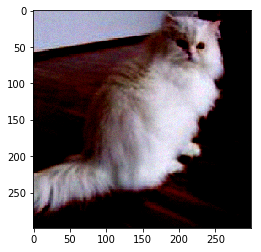

In [78]:
test_image = np.copy(hacked_image[0])

# test_image = (test_image/2 + 0.5)*255
test_image = test_image +0.1* np.random.random(np.shape(test_image))
test_image = np.expand_dims(test_image, axis=0)
test_cost, test_gradients, test_predict = grab_cost_and_gradients_from_model([test_image,0])
print( np.argsort(test_predict[0])[-5:])
print( np.sort(test_predict[0])[-5:])
print("test the image is a toaster: {:.8}%".format(test_cost * 100))
plt.figure()
plt.imshow(test_image[0])
plt.show()

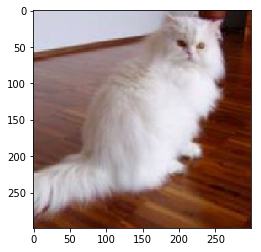

[[[216 217 220]
  [212 213 218]
  [209 210 218]
  ...
  [  8  22  57]
  [ 17  31  69]
  [ 27  39  78]]

 [[216 217 221]
  [211 212 218]
  [207 209 218]
  ...
  [ 18  34  76]
  [ 24  40  85]
  [ 27  43  89]]

 [[213 214 218]
  [209 211 217]
  [207 209 219]
  ...
  [ 19  36  86]
  [ 21  40  92]
  [ 22  41  93]]

 ...

 [[ 57  65 101]
  [ 31  42  84]
  [ 27  41  89]
  ...
  [  6  15  66]
  [  5  12  58]
  [  5  11  52]]

 [[ 55  62  96]
  [ 30  39  79]
  [ 27  39  84]
  ...
  [ 10  17  65]
  [  9  14  58]
  [  8  12  51]]

 [[ 53  60  90]
  [ 27  36  72]
  [ 26  38  77]
  ...
  [ 12  19  62]
  [ 10  15  55]
  [ 10  14  49]]]


In [72]:
test_image = np.copy(hacked_image[0])
test_image = (test_image/2 + 0.5)*255
now_image = test_image.astype(np.uint8)
plt.figure()
plt.imshow(now_image)
plt.show()
delta = test_image - now_image
# test_image = np.reshape(test_image,[-1])
print(np.sort(now_image))


In [61]:
print(np.sort(now_image))

[[[216 217 220]
  [212 213 218]
  [209 210 218]
  ...
  [  8  22  57]
  [ 17  31  69]
  [ 27  39  78]]

 [[216 217 221]
  [211 212 218]
  [207 209 218]
  ...
  [ 18  34  76]
  [ 24  40  85]
  [ 27  43  89]]

 [[213 214 218]
  [209 211 217]
  [207 209 219]
  ...
  [ 19  36  86]
  [ 21  40  92]
  [ 22  41  93]]

 ...

 [[ 57  65 101]
  [ 31  42  84]
  [ 27  41  89]
  ...
  [  6  15  66]
  [  5  12  58]
  [  5  11  52]]

 [[ 55  62  96]
  [ 30  39  79]
  [ 27  39  84]
  ...
  [ 10  17  65]
  [  9  14  58]
  [  8  12  51]]

 [[ 53  60  90]
  [ 27  36  72]
  [ 26  38  77]
  ...
  [ 12  19  62]
  [ 10  15  55]
  [ 10  14  49]]]
